In [1]:
library(synapser)
synLogin()



TERMS OF USE NOTICE:
  When using Synapse, remember that the terms and conditions of use require that you:
  1) Attribute data contributors when discussing these data or results from these data.
  2) Not discriminate, identify, or recontact individuals or groups represented by the data.
  3) Use and contribute only data de-identified to HIPAA standards.
  4) Redistribute data only under these same terms of use.



Welcome, Brian White!

NULL

In [2]:
library(dplyr)
library(plyr)
library(ggpubr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

Loading required package: ggplot2

Attaching package: ‘ggpubr’

The following object is masked from ‘package:plyr’:

    mutate



In [3]:
## Read in the prediction results from the validation phase
synId <- "syn22267537"
validation.result.tbl <- synTableQuery(paste0("SELECT * FROM ", synId))
## validation.result.tbl <- as.data.frame(validation.result.tbl)
validation.result.tbl <- validation.result.tbl$asDataFrame()

validation.result.tbl <- subset(validation.result.tbl, team != "gold")




In [4]:

summarized.validation.result.tbl <-
  ddply(validation.result.tbl, .variables = c("inhibitor"),
        .fun = function(df) {
                 data.frame(spearman = median(as.numeric(df$spearman), na.rm=TRUE), pearson = median(as.numeric(df$pearson), na.rm=TRUE))
               })

o <- order(summarized.validation.result.tbl$spearman, decreasing=FALSE)
summarized.validation.result.tbl <- summarized.validation.result.tbl[o, ]
validation.result.tbl$inhibitor <- factor(validation.result.tbl$inhibitor, levels = summarized.validation.result.tbl$inhibitor)

validation.result.tbl$color <- "black"
validation.result.tbl[validation.result.tbl$team == "AAUH","color"] <- "red"


Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs introduced by coercion”Warning message in median(as.numeric(df$pearson), na.rm = TRUE):
“NAs 

In [5]:
is_low_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x))
}

is_high_outlier <- function(x) {
  return(x > quantile(x, 0.75) + 1.5 * IQR(x))
}

is_outlier <- function(x) {
  return(is_low_outlier(x) | is_high_outlier(x))
}

In [6]:
validation.result.tbl <- 
    validation.result.tbl %>% 
    group_by(inhibitor) %>% 
    mutate(high_outlier = is_high_outlier(spearman)) %>%
    mutate(low_outlier = is_low_outlier(spearman)) 

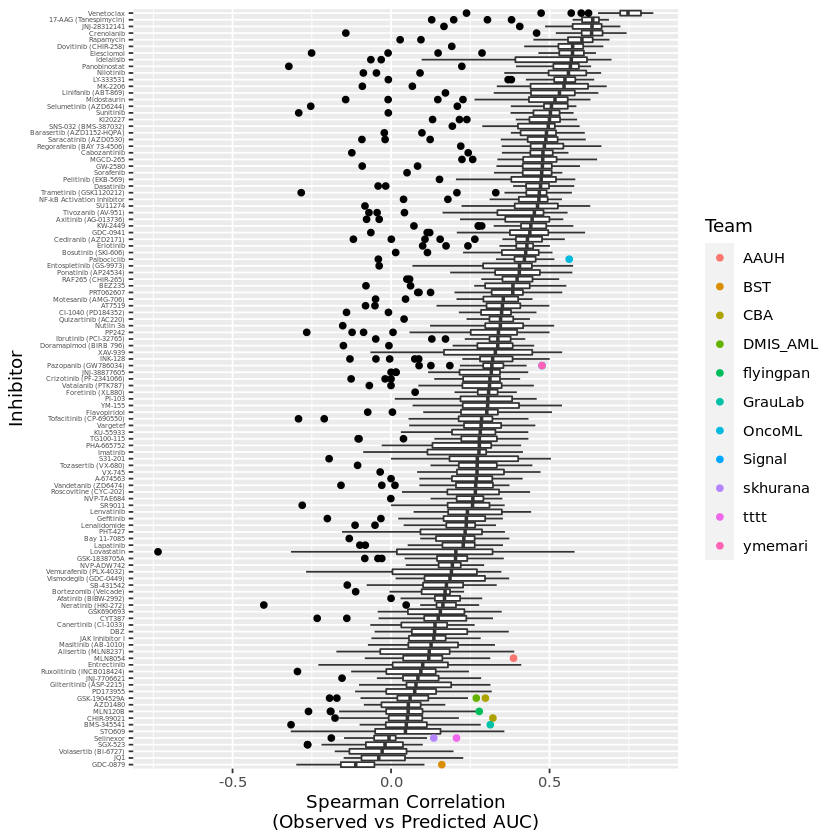

In [7]:
g <- ggplot()
g <- g + geom_boxplot(data = validation.result.tbl, aes(x = inhibitor, y = spearman), outlier.shape=NA)
g <- g + geom_point(data = subset(validation.result.tbl, high_outlier == TRUE), aes(x = inhibitor, y = spearman, colour = team))
g <- g + geom_point(data = subset(validation.result.tbl, low_outlier == TRUE), aes(x = inhibitor, y = spearman))
g <- g + xlab("Inhibitor") + ylab("Spearman Correlation\n(Observed vs Predicted AUC)")
g <- g + theme(axis.text.y = element_text(size = 4))
g <- g + labs(colour='Team')
g <- g + coord_flip()
g
png("beat-aml-sc1-per-drug-score-distributions.png")
print(g)
d <- dev.off()
pdf("beat-aml-sc1-per-drug-score-distributions.pdf")
print(g)
d <- dev.off()

In [8]:
cat(paste0("Number of high outliers: ", nrow(subset(validation.result.tbl, high_outlier == TRUE)), "\n"))
cat(paste0("Number of teams w/ high outliers: ", length(unique(subset(validation.result.tbl, high_outlier == TRUE)$team)), "\n"))
high.outlier.teams <- as.data.frame(table(subset(validation.result.tbl, high_outlier == TRUE)$team))
colnames(high.outlier.teams) <- c("team", "num.high.outliers")
cat(paste0("Number of teams w/ multiple high-outliers: ", nrow(subset(high.outlier.teams, num.high.outliers > 1)), "\n"))

cat(paste0("Number of low outliers: ", nrow(subset(validation.result.tbl, low_outlier == TRUE)), "\n"))
cat(paste0("Number of teams w/ low outliers: ", length(unique(subset(validation.result.tbl, low_outlier == TRUE)$team)), "\n"))
low.outlier.teams <- as.data.frame(table(subset(validation.result.tbl, low_outlier == TRUE)$team))
colnames(low.outlier.teams) <- c("team", "num.low.outliers")
cat(paste0("Number of teams w/ multiple low-outliers: ", nrow(subset(low.outlier.teams, num.low.outliers > 1)), "\n"))
outlier.teams <- merge(high.outlier.teams, low.outlier.teams, all=TRUE)
outlier.teams

Number of high outliers: 12
Number of teams w/ high outliers: 11
Number of teams w/ multiple high-outliers: 1
Number of low outliers: 178
Number of teams w/ low outliers: 15
Number of teams w/ multiple low-outliers: 12


team,num.high.outliers,num.low.outliers
AAUH,1,NA
BST,1,58
CBA,2,NA
DMIS_AML,1,1
flyingpan,1,NA
GrauLab,1,10
OncoML,1,41
Signal,1,3
skhurana,1,NA
tttt,1,NA


In [9]:
indices <- seq(from=nrow(summarized.validation.result.tbl),to=2)
names(indices) <- summarized.validation.result.tbl[indices,"inhibitor"]
consecutive.diffs <- 
   ldply(indices,
         .fun = function(i) {
                  data.frame(spearman.diff = summarized.validation.result.tbl[i,"spearman"] - summarized.validation.result.tbl[i-1,"spearman"],
                             pearson.diff = summarized.validation.result.tbl[i,"pearson"] - summarized.validation.result.tbl[i-1,"pearson"])
         })
colnames(consecutive.diffs)[1] <- "inhibitor"
# Venetoclax has the larger improvement relative to other drugs
print(consecutive.diffs[which.max(abs(consecutive.diffs$spearman.diff)),])
o <- order(consecutive.diffs$spearman.diff)
print(consecutive.diffs[o,])

   inhibitor spearman.diff pearson.diff
1 Venetoclax     0.1112442    0.1471085
                     inhibitor spearman.diff  pearson.diff
65                   TG100-115  1.767742e-05  0.0121912868
77                   Gefitinib  3.850601e-04 -0.0082196754
68                     S31-201  4.091175e-04  0.0301740221
42                      BEZ235  4.306500e-04  0.0175797523
50       Ibrutinib (PCI-32765)  4.423752e-04  0.0297373071
6         Dovitinib (CHIR-258)  4.817124e-04  0.0224034856
69         Tozasertib (VX-680)  5.260082e-04  0.0697630736
105                    AZD1480  5.569886e-04 -0.0568460995
47         Quizartinib (AC220)  7.041615e-04 -0.0231973246
22                Cabozantinib  7.953922e-04 -0.0263313119
39     Entospletinib (GS-9973)  8.003000e-04 -0.0271650213
59                      PI-103  8.388702e-04 -0.0462761795
82                  Lovastatin  1.021531e-03 -0.0655019824
74                  NVP-TAE684  1.065214e-03 -0.0219023259
23                    MGCD-265  1.0

In [10]:
setwd("/projects/compsci/whitebr/CTD2-BeatAML-Challenge/analysis")
# setwd("/home/whitebr/")

Welcome, Brian White!

Warning message:
"package 'rpubchem' is not available (for R version 3.6.1)"Warning message in p_install(package, character.only = TRUE, ...):
""Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'rpubchem'"Warning message in p_load(rpubchem):
"Failed to install/load:
rpubchem"

Registering 71 cores.


Warning message in eval(ei, envir):
"NAs introduced by coercion"

28 teams submitted to SC1
Reading expr  syn21212911 
Reading expr file  /home/whitebr/.synapseCache/605/46802605/rnaseq.csv 


Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Warning message in parse.smiles(sm):
"1 out of 1 SMILES were not successfully parsed, resulting in NULLs."Using cor as value column: use value.var to override.
Using cor as value column: use value.var to override.
Using cor as value column: use value.var to 

ERROR: Error in eval(ei, envir): stop


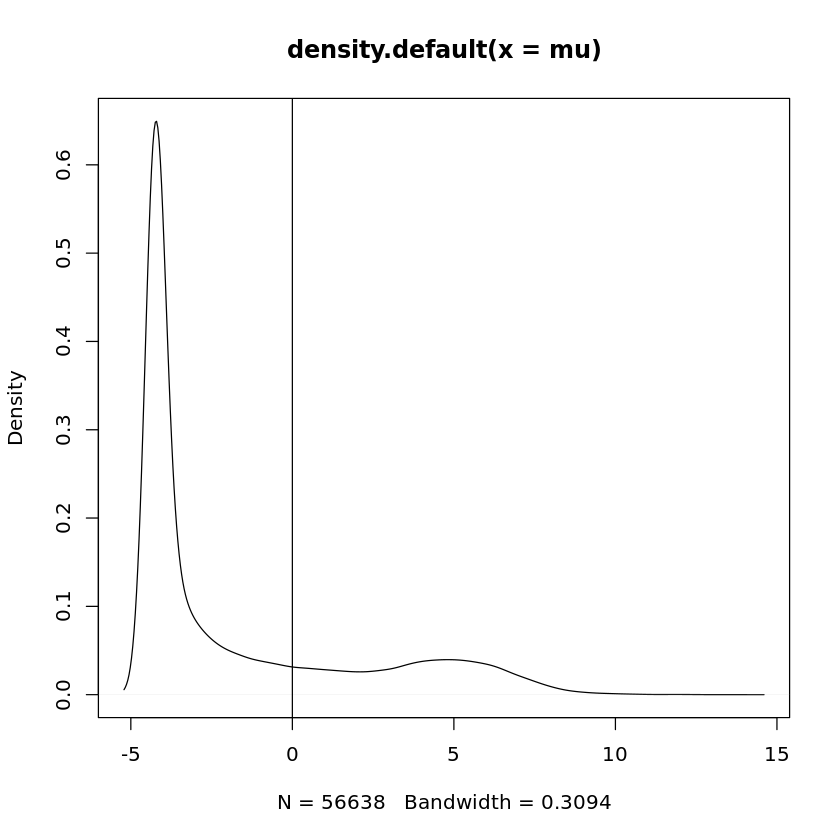

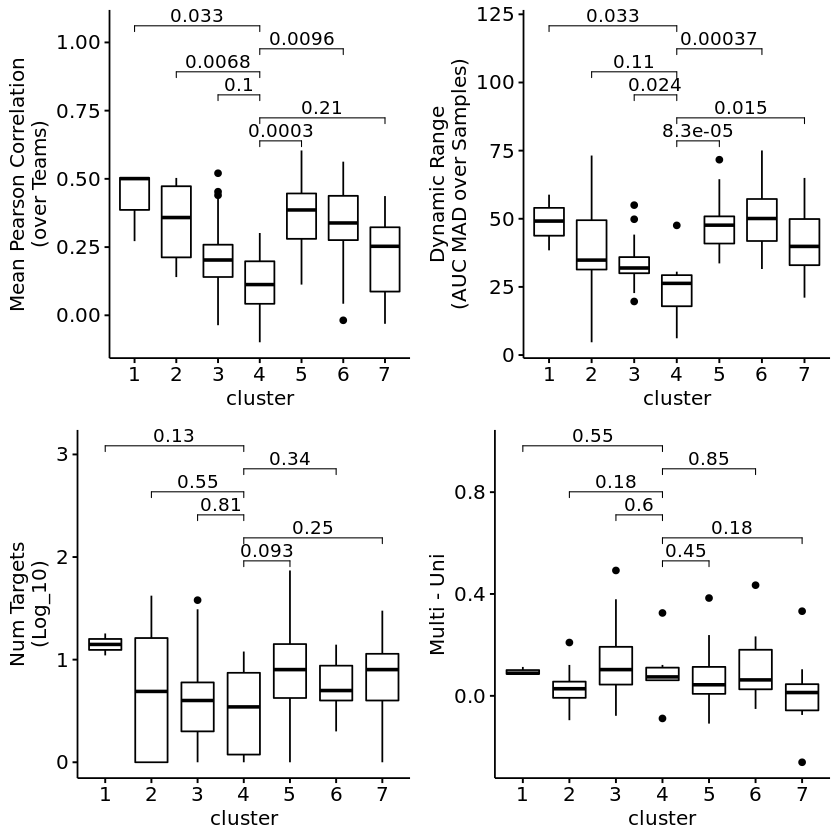

In [11]:
source("/home/whitebr/sc1-analysis.R")

In [12]:
df <- renamed.aucs[["training"]]
df <- t(df)
df2 <- df / rowSums(df, na.rm=TRUE)
norm.entropy <- function(x) {
    x.na <- x[!is.na(x)]
    return (-sum(x.na * log(x.na)) / length(x.na) )
}

entropy.vals <- apply(df2, 1, norm.entropy)
entropy.df <- data.frame(inhibitor = rownames(df), entropy = entropy.vals)
head(all.tbl)

inhibitor,cluster,range,mean.correlation,num.targets,log.num.targets,max.mean.pchembl,multi.vs.uni
17-AAG (Tanespimycin),5,48.47270,0.5820691,4,0.6020600,7.51,-0.03564947
A-674563,7,46.81738,0.2529311,10,1.0000000,7.80,0.04617183
Afatinib (BIBW-2992),7,28.32277,0.1616841,4,0.6020600,9.18,0.04423390
Alisertib (MLN8237),3,30.67703,0.0950643,3,0.4771213,8.96,0.22529146
AT7519,2,30.98240,0.3315682,16,1.2041200,8.00,-0.09590242
Axitinib (AG-013736),5,42.75631,0.3983606,3,0.4771213,10.00,0.15036075


In [13]:
all.tbl <- merge(drug.clusters, drug.range.tbl, all.x = TRUE)
all.tbl <- merge(all.tbl, mean.perf.tbl, all.x = TRUE)
all.tbl <- all.tbl[!(all.tbl$inhibitor == "GRD"),]
ohsu.drug.targets <- read.table("ohsu-drug-targets.tsv", sep="\t", header=TRUE)
# Ensure a minimum drug binding
cutoff <- -log10(100*10^-9)
ohsu.drug.targets$log.num.targets <- log10(ohsu.drug.targets$num.targets)
ohsu.drug.targets[ohsu.drug.targets$max.mean.pchembl < cutoff, "num.targets"] <- NA
ohsu.drug.targets[ohsu.drug.targets$max.mean.pchembl < cutoff, "log.num.targets"] <- NA
all.tbl <- merge(all.tbl, ohsu.drug.targets[, c("inhibitor", "num.targets", "log.num.targets", "max.mean.pchembl")], all.x=TRUE)
all.tbl <- merge(all.tbl, multi.vs.uni.df, all.x=TRUE)



In [14]:
cluster.names <- unique(all.tbl$cluster)
my_comparisons <-
    llply(cluster.names[cluster.names != "4"], .fun = function(cl) c("4", cl))

all.tbl$cluster <- factor(all.tbl$cluster, levels = sort(unique(all.tbl$cluster)))


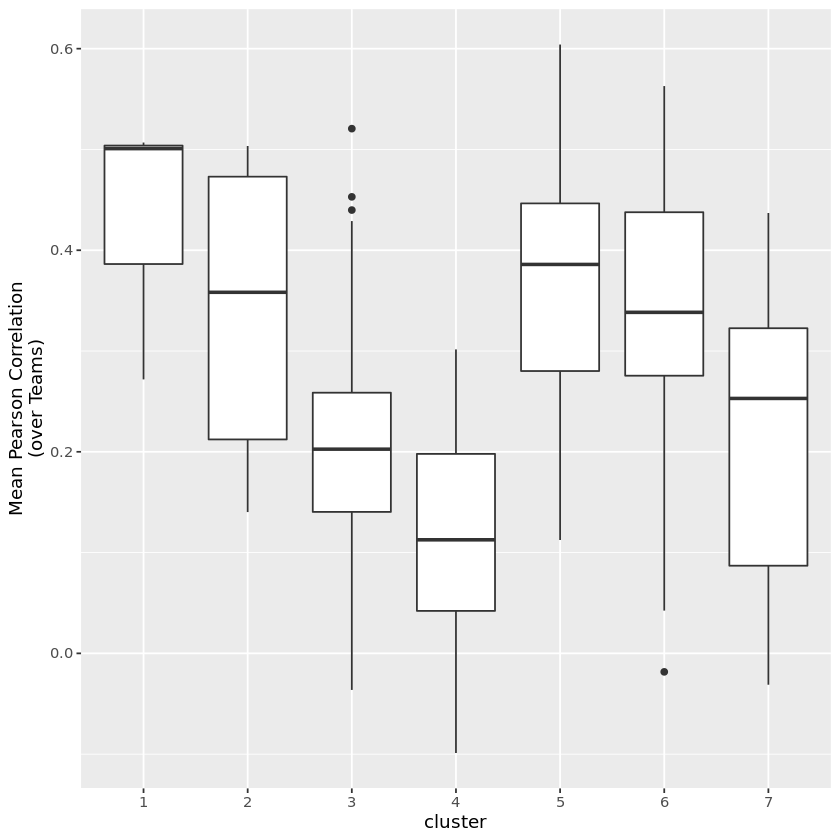

In [15]:
g1 <- ggplot(data = all.tbl)
g1 <- g1 + geom_boxplot(aes(x = cluster, y = mean.correlation))
g1 <- g1 + ylab("Mean Pearson Correlation\n(over Teams)")

g1

Warning message:
"Removed 19 rows containing non-finite values (stat_boxplot)."Warning message:
"Removed 19 rows containing non-finite values (stat_signif)."Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(c(NA, 0.301029995663981, 0, 0, 1.07918124604762, :
"cannot compute exact p-value with ties"Warning message:
"Removed 3 rows containing non-finite values (

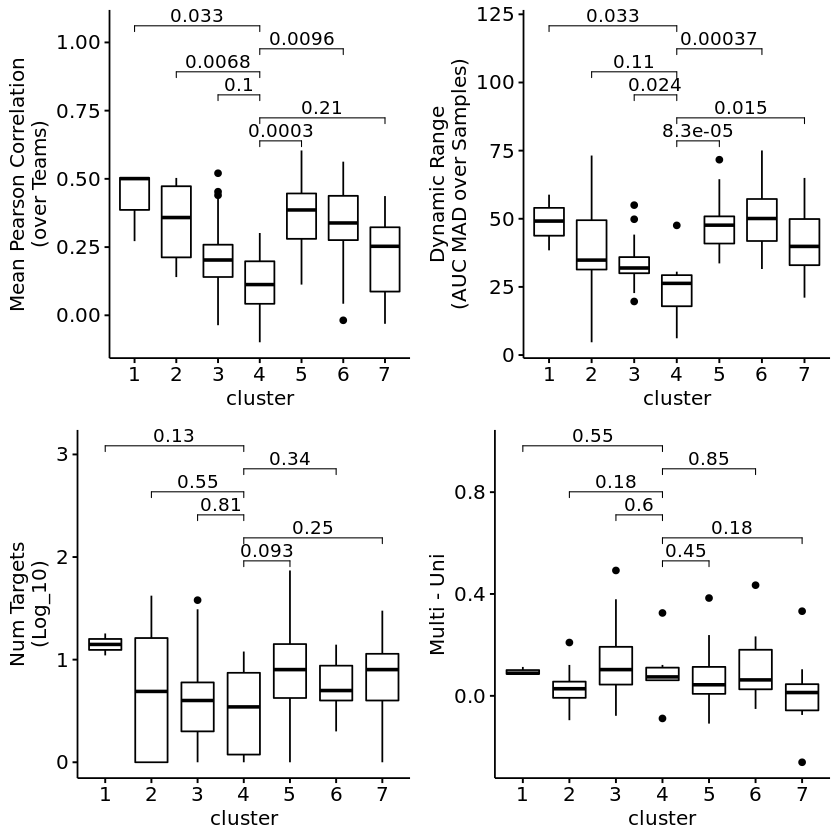

In [16]:
g1 <- ggboxplot(data = all.tbl, x = "cluster", y = "mean.correlation")
g1 <- g1 + ylab("Mean Pearson Correlation\n(over Teams)")
g1 <- g1 + stat_compare_means(comparison = my_comparisons)

g2 <- ggboxplot(data = all.tbl, x = "cluster", y = "range")
g2 <- g2 + ylab("Dynamic Range\n(AUC MAD over Samples)")
g2 <- g2 + stat_compare_means(comparison = my_comparisons)

g3 <- ggboxplot(data = all.tbl, x = "cluster", y = "log.num.targets")
g3 <- g3 + ylab("Num Targets\n(Log_10)")
g3 <- g3 + stat_compare_means(comparison = my_comparisons)

g4 <- ggboxplot(data = all.tbl, x = "cluster", y = "multi.vs.uni")
g4 <- g4 + ylab("Multi - Uni")
g4 <- g4 + stat_compare_means(comparison = my_comparisons)

grid.arrange(g1,g2,g3,g4)



[1] 0.1967964
[1] 0.1540576


[1] 0.1872459

[1] 0.4712974

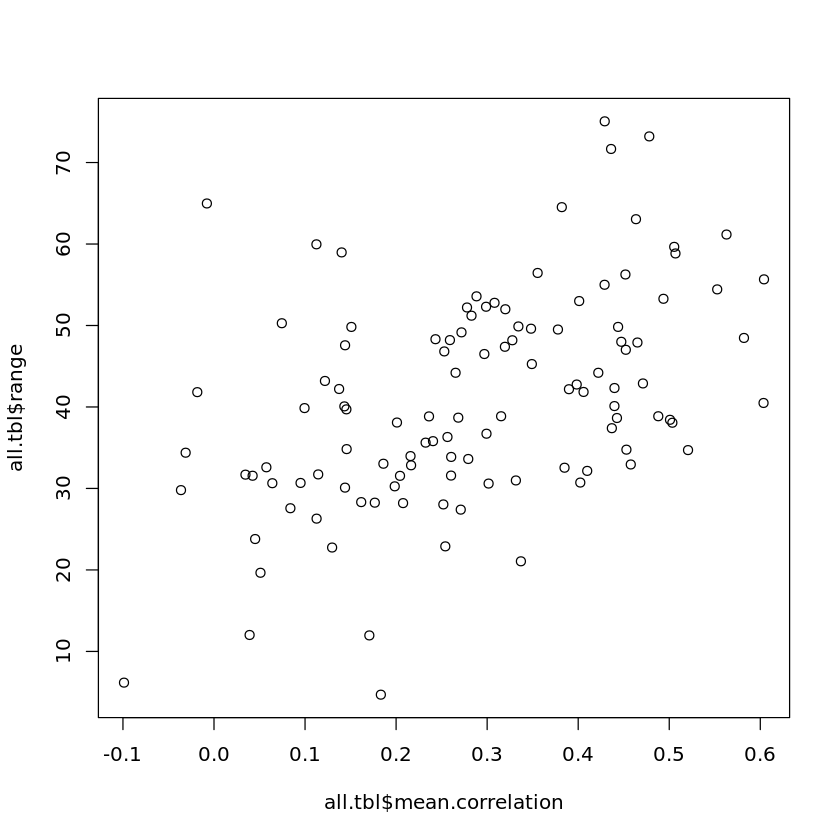

In [17]:
print(cor(all.tbl$mean.correlation, all.tbl$log.num.targets, use = "pairwise.complete.obs", method = "pearson"))
print(cor(all.tbl$mean.correlation, all.tbl$num.targets, use = "pairwise.complete.obs", method = "pearson"))
plot(all.tbl$mean.correlation, all.tbl$range)
foo <- subset(all.tbl, max.mean.pchembl > 6.5)
#plot(all.tbl$mean.correlation, all.tbl$max.mean.pchembl)
#cor(foo$mean.correlation, foo$max.mean.pchembl, use = "pairwise.complete.obs", method = "pearson")
#plot(all.tbl$mean.correlation, all.tbl$log.num.targets)
#plot(all.tbl$range, all.tbl$log.num.targets)
cor(all.tbl$mean.correlation, all.tbl$max.mean.pchembl, use = "pairwise.complete.obs", method = "pearson")
cor(all.tbl$mean.correlation, all.tbl$range, use = "pairwise.complete.obs", method = "pearson")
#all.tbl

In [18]:
cor(all.tbl$mean.correlation, all.tbl$entropy, use = "pairwise.complete.obs", method = "spearman")
plot(all.tbl$mean.correlation, all.tbl$entropy)
text(all.tbl$mean.correlation, all.tbl$entropy, labels = all.tbl$inhibitor)

ERROR: Error in cor(all.tbl$mean.correlation, all.tbl$entropy, use = "pairwise.complete.obs", : supply both 'x' and 'y' or a matrix-like 'x'


In [19]:
mean.all.tbl <- ddply(all.tbl, .variables = c("cluster"), 
                      .fun = function(df) { 
                          data.frame(mean.cor = mean(df$mean.correlation, na.rm=TRUE),
                                    mean.range = mean(df$range, na.rm=TRUE))
                      })

In [20]:
cor(mean.all.tbl$mean.cor, mean.all.tbl$mean.range)

[1] 0.8193866

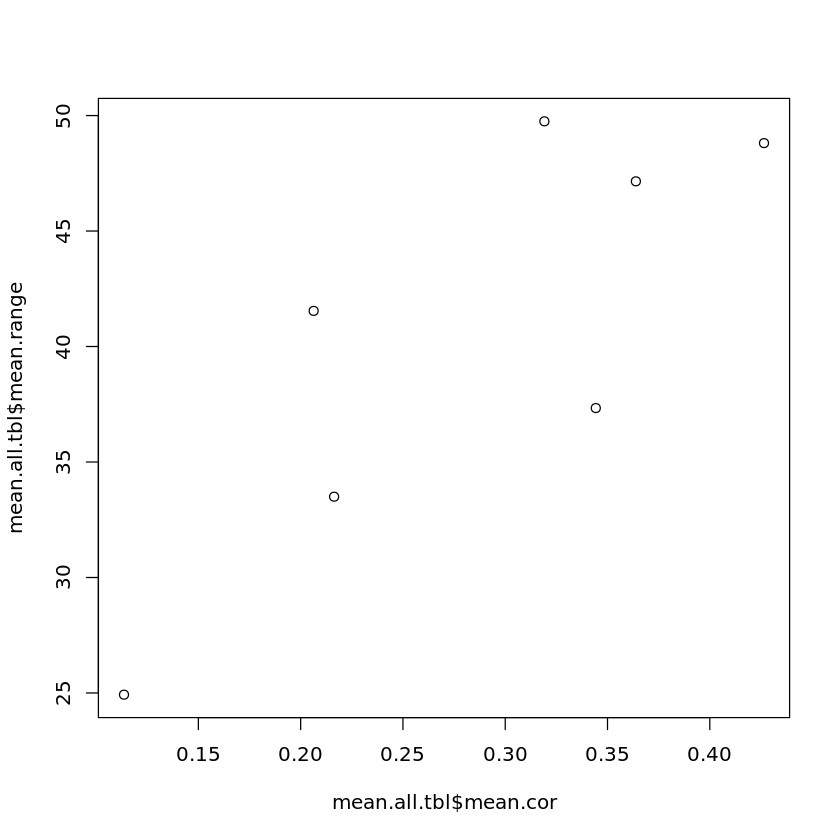

In [21]:
plot(mean.all.tbl$mean.cor, mean.all.tbl$mean.range)

In [22]:
source("reconcile-drugs.R")

Welcome, Brian White!Calculating all pairwise Tanimoto distances between ohsu.smiles drug fingerprints and klaeger.smiles drug fingerprints
Calculating drug fingerprints for OHSU
Calculating drug fingerprints for Kraeger
Calculating all pairwise Tanimoto distances between ohsu.smiles drug fingerprints and klaeger.smiles drug fingerprints


ERROR: Error in read.xlsx.default("EMS82808_Table_S6.xlsx", sheet = 2): File does not exist.


In [26]:
klaeger.catds <- read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=2)
klaeger.catds <-
  ddply(klaeger.catds, .variables = c("Drug"),
      .fun = function(df) { data.frame(CATDS = max(df$CATDS)) } )


In [31]:
struct.mapping <- map.drug.structures.based.on.fingerprints(fp.ohsu, fp.klaeger, "ohsu.smiles", "klaeger.smiles", tanimoto.cutoff = 0.9)
struct.mapping

Calculating all pairwise Tanimoto distances between ohsu.smiles drug fingerprints and klaeger.smiles drug fingerprints


ohsu.smiles,klaeger.smiles
Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](CN2CCCC2)C1,Nc1ncnc2c1c(cn2[C@@H]3C[C@H](C3)N4CCC4)c5cccc(OCc6ccccc6)c5


In [32]:
fp.ohsu <- parseInputFingerprint(unique(as.character(ohsu.drug.anno$smiles)))
klaeger.smiles <- na.omit(as.character(klaeger.anno$SMILES.code))
names(klaeger.smiles) <- klaeger.smiles
fp.klaeger <- parseInputFingerprint(unique(klaeger.smiles))
# fp.klaeger <- llply(klaeger.smiles, parseSingleInputFingerprint)

struct.mapping <- map.drug.structures.based.on.fingerprints(fp.ohsu, fp.klaeger, "ohsu.smiles", "klaeger.smiles", tanimoto.cutoff = 0.9)
struct.mapping




Calculating all pairwise Tanimoto distances between ohsu.smiles drug fingerprints and klaeger.smiles drug fingerprints


ohsu.smiles,klaeger.smiles
Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1,Clc1ccc(Nc2nnc(Cc3ccncc3)c4ccccc24)cc1
N#CCNC(=O)c1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2)cc1,O=C(NCC#N)c1ccc(cc1)c2ccnc(Nc3ccc(cc3)N4CCOCC4)n2
NC1(c2ccc(-c3nc4ccn5c(=O)[nH]nc5c4cc3-c3ccccc3)cc2)CCC1,NC1(CCC1)c2ccc(cc2)c3nc4C=CN5C(=O)NN=C5c4cc3c6ccccc6
Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)cc1C#Cc1cnc2cccnn12,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc4cnc5cccnn45)cc2C(F)(F)F)CC1
CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1,CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]4CCOC4
CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(-c4ccc(Cl)cc4)cc23)c1F,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(cc23)c4ccc(Cl)cc4)c1F
COc1cc2c(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3F)ccnc2cc1OCCCN1CCOCC1,COc1cc2c(Oc3ccc(NC(=O)C4(CC4)C(=O)Nc5ccc(F)cc5)cc3F)ccnc2cc1OCCCN6CCOCC6
Cc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)ncc2Cl)[nH]n1,C[C@H](Nc1ncc(Cl)c(Nc2cc(C)n[nH]2)n1)c3ncc(F)cn3
Cn1cc(-c2ccc3nnc(Sc4ccc5ncccc5c4)n3n2)cn1,Cn1cc(cn1)c2ccc3nnc(Sc4ccc5ncccc5c4)n3n2
COc1cc2c(N3CCN(C(=O)Nc4ccc(OC(C)C)cc4)CC3)ncnc2cc1OCCCN1CCCCC1,COc1cc2c(ncnc2cc1OCCCN3CCCCC3)N4CCN(CC4)C(=O)Nc5ccc(OC(C)C)cc5


In [33]:
reconciled <- merge(ohsu.drug.anno[, c("inhibitor", "smiles")], struct.mapping, by.x = "smiles", by.y = "ohsu.smiles")
reconciled <- merge(reconciled, klaeger.anno[, c("Drug", "SMILES.code")], by.x = "klaeger.smiles", "SMILES.code")
reconciled <- merge(reconciled,	klaeger.catds)




In [34]:
reconciled

Drug,klaeger.smiles,smiles,inhibitor,CATDS
AEW-541,Nc1ncnc2c1c(cn2[C@@H]3C[C@H](C3)N4CCC4)c5cccc(OCc6ccccc6)c5,Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](CN2CCCC2)C1,NVP-ADW742,0.1287897
Afatinib,CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]4CCOC4,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1,Afatinib (BIBW-2992),0.9948695
Alisertib,COc1cccc(F)c1C2=NCc3cnc(Nc4ccc(C(=O)O)c(OC)c4)nc3c5ccc(Cl)cc25,COc1cc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)cccc2OC)=NC3)ccc1C(=O)O,Alisertib (MLN8237),0.8120939
Alvocidib,CN1CC[C@@H]([C@H](O)C1)c2c(O)cc(O)c3C(=O)C=C(Oc23)c4ccccc4Cl,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)[C@H](O)C1,Flavopiridol,0.3824031
AT-7519,Clc1cccc(Cl)c1C(=O)Nc2c[nH]nc2C(=O)NC3CCNCC3,O=C(NC1CCNCC1)c1n[nH]cc1NC(=O)c1c(Cl)cccc1Cl,AT7519,0.2735003
Axitinib,CNC(=O)c1ccccc1Sc2ccc3c(\C=C\c4ccccn4)n[nH]c3c2,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,Axitinib (AG-013736),0.2119560
AZD-1480,C[C@H](Nc1ncc(Cl)c(Nc2cc(C)n[nH]2)n1)c3ncc(F)cn3,Cc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)ncc2Cl)[nH]n1,AZD1480,0.1539648
BMS-387032,CC(C)(C)c1oc(CSc2cnc(NC(=O)C3CCNCC3)s2)nc1,CC(C)(C)c1cnc(CSc2cnc(NC(=O)C3CCNCC3)s2)o1,SNS-032 (BMS-387032),0.8417680
Bosutinib,COc1cc(Nc2c(cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)C#N)c(Cl)cc1Cl,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc23)c(Cl)cc1Cl,Bosutinib (SKI-606),0.2785039
Cabozantinib,COc1cc2nccc(Oc3ccc(NC(=O)C4(CC4)C(=O)Nc5ccc(F)cc5)cc3)c2cc1OC,COc1cc2nccc(Oc3ccc(NC(=O)C4(C(=O)Nc5ccc(F)cc5)CC4)cc3)c2cc1OC,Cabozantinib,0.4570801


In [36]:
print(nrow(all.tbl))
tmp <- merge(all.tbl, reconciled[, c("inhibitor", "CATDS")])
print(nrow(tmp))

[1] 113
[1] 60


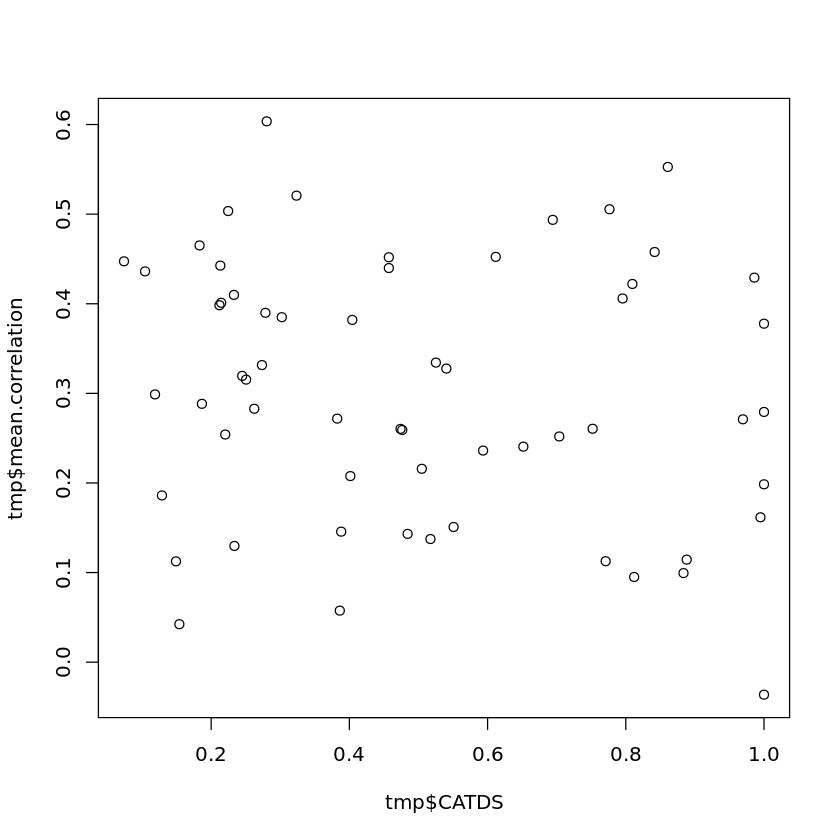

In [40]:
plot(tmp$CATDS, tmp$mean.correlation)

In [74]:
klaeger.stats <- list()
klaeger.stats.tabs <- list("most" = 4, "least" = 5, "most.global" = 6)
klaeger.stats <-
  llply(klaeger.stats.tabs, .parallel=FALSE,
        .fun = function(tab) {
                      klaeger.stats <- read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=tab, startRow = 5)
                      stat.cols <- c("Number.of.targets", "Gini", "Selectivity", "Partition.index.single", "CATDS.single", "Entropy")
                        stat.cols <- c(stat.cols, colnames(klaeger.stats)[grepl(x=colnames(klaeger.stats), pattern="Gini.")])
                        stat.cols <- c(stat.cols, colnames(klaeger.stats)[grepl(x=colnames(klaeger.stats), pattern="Selectivity.")])
                stat.cols	<- unique(stat.cols)
            stat.cols <- stat.cols[stat.cols %in% colnames(klaeger.stats)]
                      klaeger.stats <- klaeger.stats[, c("Drug", stat.cols)]
            klaeger.stats
                    })

In [156]:
read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=5, startRow = 5)

Drug,Designated.targets,Number.of.targets,Concentration,Reference.protein,Gini,Selectivity,Partition.index.single,CATDS.single,Gini.10.nM,...,Entropy,Reference.targets,CATDS.multi,CATDS.multi.10.nM,CATDS.multi.50.nM,CATDS.multi.100.nM,CATDS.multi.500.nM,CATDS.multi.1000.nM,CATDS.multi.5000.nM,Partition.index.multi
Abemaciclib,"CDK4,CDK6",43,96.549434,CDK4,0.9387068,0.048442907,0.0103496468,0.03327511,0.9631685,...,2.435994587,CDK6;CDK4,0.08115617,0.0078711237,0.035141927,0.096920033,0.09814114,0.08585636,0.06660669,0.027413213
AC-480,"EGFR,ERBB2",1,2.549945,EGFR,0.9963768,0.003546099,1.0000000000,1.00000000,0.9963768,...,0.000000000,EGFR,1.00000000,1.0000000000,1.000000000,1.000000000,1.00000000,1.00000000,1.00000000,1.000000000
ACTB-1003,FGFR1,15,40.264407,FGFR1,0.9843725,0.003311258,0.5514349689,0.48569189,0.9894668,...,1.428792606,FGFR1,0.48569189,0.6506414537,0.443965194,0.314762654,0.18511071,0.14703522,0.09014038,0.551434969
AEE-788,"EGFR,ERBB2",26,402.554656,EGFR,0.9555839,0.003257329,0.2543439327,0.13067376,0.9616309,...,2.176746889,EGFR,0.13067376,0.1019878842,0.128593247,0.135373081,0.12749656,0.11442274,0.08119888,0.254343933
AEW-541,"IGF1R,INSR",25,9769.292008,IGF1R,0.9319233,0.069444444,0.0049784439,0.03180476,0.9702312,...,2.281236602,INSR;IGF1R,0.07219821,0.0909241715,0.085453224,0.080479888,0.07434314,0.07458850,0.07114871,0.017014623
Afatinib,EGFR,9,2.385739,EGFR,0.9965464,0.003300330,0.9903740020,0.99486949,0.9964474,...,0.071512716,EGFR,0.99486949,0.9868468967,0.922631495,0.845306619,0.50341420,0.34978570,0.15510019,0.990374002
Alectinib,ALK,10,NA,NA,NA,NA,NA,NA,0.9877107,...,1.624813916,NA,NA,0.0000000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,NA
Alisertib,AURKA,18,5.373035,AURKA,0.9927929,0.003154574,0.8516338779,0.81209393,0.9925879,...,0.711015598,AURKA,0.81209393,0.8008205197,0.504385461,0.354930238,0.15634988,0.12290077,0.08110913,0.851633878
Alvocidib,"CDK1,CDK2,CDK4,CDK6",47,3259.406560,CDK6,0.9282315,0.068627451,0.0009097657,0.02788580,0.9861612,...,1.166609563,CDK2;CDK1;CDK6,0.10296981,0.0133385796,0.031223045,0.041187562,0.06809480,0.08101065,0.10873421,0.005084322
AMG-208,MET,1,28.099912,MET,0.9967638,0.003215434,1.0000000000,1.00000000,0.9967638,...,0.000000000,MET,1.00000000,1.0000000000,1.000000000,1.000000000,1.00000000,1.00000000,1.00000000,1.000000000


In [103]:
for(nm in names(klaeger.stats)) {
    reconciled <- merge(ohsu.drug.anno[, c("inhibitor", "smiles")], struct.mapping, by.x = "smiles", by.y = "ohsu.smiles")
    reconciled <- merge(reconciled, klaeger.anno[, c("Drug", "SMILES.code")], by.x = "klaeger.smiles", "SMILES.code")
    reconciled <- merge(reconciled, klaeger.catds)
    reconciled <- merge(reconciled, klaeger.stats[[nm]])
    reconciled <- merge(reconciled, all.tbl)
    stat.cols <- c("Number.of.targets", "Gini", "Selectivity", "Partition.index.single", "CATDS.single", "Entropy")
    # stat.cols <- c(stat.cols, colnames(klaeger.stats[[nm]])[grepl(x=colnames(klaeger.stats[[nm]]), pattern="Gini.")])
    # stat.cols <- c(stat.cols, colnames(klaeger.stats[[nm]])[grepl(x=colnames(klaeger.stats[[nm]]), pattern="Selectivity.")])
    stat.cols	<- unique(stat.cols)
    stat.cols <- stat.cols[stat.cols %in% colnames(klaeger.stats[[nm]])]
    for(col in stat.cols) {
        cr <- cor.test(reconciled$mean.correlation, as.numeric(reconciled[,col]), use='pairwise.complete.obs')
        cat(paste0(nm, ": ", col, " vs mean correlation =  ", cr$estimate, " p = ", cr$p.value, "\n"))
    }
        
}

most: Number.of.targets vs mean correlation =  0.290627673977095 p = 0.0242779529277428
most: Gini vs mean correlation =  -0.191438100627317 p = 0.224560540754778
most: Selectivity vs mean correlation =  -0.00601922301330687 p = 0.969821559953674
most: Partition.index.single vs mean correlation =  -0.259414961463966 p = 0.0971152819645387
most: CATDS.single vs mean correlation =  -0.209177177955547 p = 0.183691398798698
most: Entropy vs mean correlation =  0.248782166373793 p = 0.0552664025993094
least: Number.of.targets vs mean correlation =  0.290627673977095 p = 0.0242779529277428
least: Gini vs mean correlation =  -0.189562450659985 p = 0.229220547982721
least: Selectivity vs mean correlation =  0.085225549006366 p = 0.59152024942556
least: Partition.index.single vs mean correlation =  -0.363292027422004 p = 0.0180408037227902
least: CATDS.single vs mean correlation =  -0.313218847579529 p = 0.0434071470666924
least: Entropy vs mean correlation =  0.248782166373793 p = 0.0552664025

In [334]:
analysis.folder.synId <- "syn22397014"

for(nm in names(klaeger.stats)) {
    reconciled <- merge(ohsu.drug.anno[, c("inhibitor", "smiles")], struct.mapping, by.x = "smiles", by.y = "ohsu.smiles")
    reconciled <- merge(reconciled, klaeger.anno[, c("Drug", "SMILES.code")], by.x = "klaeger.smiles", "SMILES.code")
    reconciled <- merge(reconciled, klaeger.catds)
    reconciled <- merge(reconciled, klaeger.stats[[nm]])
    # reconciled <- merge(reconciled, all.tbl)
    reconciled$inhibitor.name <- unlist(lapply(reconciled$inhibitor, make.names))
    file = paste0("klaeger-drug-harmonization-table-", nm, ".tsv")
    write.table(file=file, reconciled, row.names=FALSE, col.names=TRUE, quote=FALSE, sep="\t")

    f <- File(file, parentId = analysis.folder.synId, synapseStore = TRUE)
    cat(paste0("Storing file ", file , " to Synapse\n"))
    synStore(f)
    file.remove(file)

}



Storing file klaeger-drug-harmonization-table-most.tsv to Synapse
Uploading [####################]100.00%   28.2kB/28.2kB (58.3kB/s) klaeger-drug-harmonization-table-most.tsv Done...    Storing file klaeger-drug-harmonization-table-least.tsv to Synapse
Uploading [####################]100.00%   28.2kB/28.2kB (102.4kB/s) klaeger-drug-harmonization-table-least.tsv Done...    Storing file klaeger-drug-harmonization-table-most.global.tsv to Synapse
Uploading [####################]100.00%   16.7kB/16.7kB (65.8kB/s) klaeger-drug-harmonization-table-most.global.tsv Done...    ########

In [254]:
reconciled <- merge(ohsu.drug.anno[, c("inhibitor", "smiles")], struct.mapping, by.x = "smiles", by.y = "ohsu.smiles")
reconciled <- merge(reconciled, klaeger.anno[, c("Drug", "SMILES.code")], by.x = "klaeger.smiles", "SMILES.code")
reconciled <- merge(reconciled, klaeger.catds)
reconciled <- merge(reconciled, klaeger.stats[["most.global"]])
reconciled$inhibitor.name <- unlist(lapply(reconciled$inhibitor, make.names))

In [253]:
head(reconciled)

Drug,klaeger.smiles,smiles,inhibitor,CATDS,Number.of.targets,Gini,Selectivity,Partition.index.single,CATDS.single,Entropy
AEW-541,Nc1ncnc2c1c(cn2[C@@H]3C[C@H](C3)N4CCC4)c5cccc(OCc6ccccc6)c5,Nc1ncnc2c1c(-c1cccc(OCc3ccccc3)c1)cn2[C@H]1C[C@H](CN2CCCC2)C1,NVP-ADW742,0.1287897,25,0.9564846,0.003472222,0.3335268,0.1287897,2.28123660
Afatinib,CN(C)C\C=C\C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]4CCOC4,CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1,Afatinib (BIBW-2992),0.9948695,9,0.9965464,0.003300330,0.9903740,0.9948695,0.07151272
Alisertib,COc1cccc(F)c1C2=NCc3cnc(Nc4ccc(C(=O)O)c(OC)c4)nc3c5ccc(Cl)cc25,COc1cc(Nc2ncc3c(n2)-c2ccc(Cl)cc2C(c2c(F)cccc2OC)=NC3)ccc1C(=O)O,Alisertib (MLN8237),0.8120939,18,0.9927929,0.003154574,0.8516339,0.8120939,0.71101560
Alvocidib,CN1CC[C@@H]([C@H](O)C1)c2c(O)cc(O)c3C(=O)C=C(Oc23)c4ccccc4Cl,CN1CC[C@H](c2c(O)cc(O)c3c(=O)cc(-c4ccccc4Cl)oc23)[C@H](O)C1,Flavopiridol,0.3824031,47,0.9851077,0.003267974,0.4594067,0.3824031,1.16660956
AT-7519,Clc1cccc(Cl)c1C(=O)Nc2c[nH]nc2C(=O)NC3CCNCC3,O=C(NC1CCNCC1)c1n[nH]cc1NC(=O)c1c(Cl)cccc1Cl,AT7519,0.2735003,32,0.9828551,0.003472222,0.2955884,0.2735003,1.67297926
Axitinib,CNC(=O)c1ccccc1Sc2ccc3c(\C=C\c4ccccn4)n[nH]c3c2,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,Axitinib (AG-013736),0.2119560,24,0.9771624,0.003278689,0.2571038,0.2119560,2.42682470


In [105]:
tmp <- merge(all.tbl, reconciled)

In [106]:
cor(tmp$mean.correlation, tmp$Gini, use='pairwise.complete.obs')

[1] -0.1942957

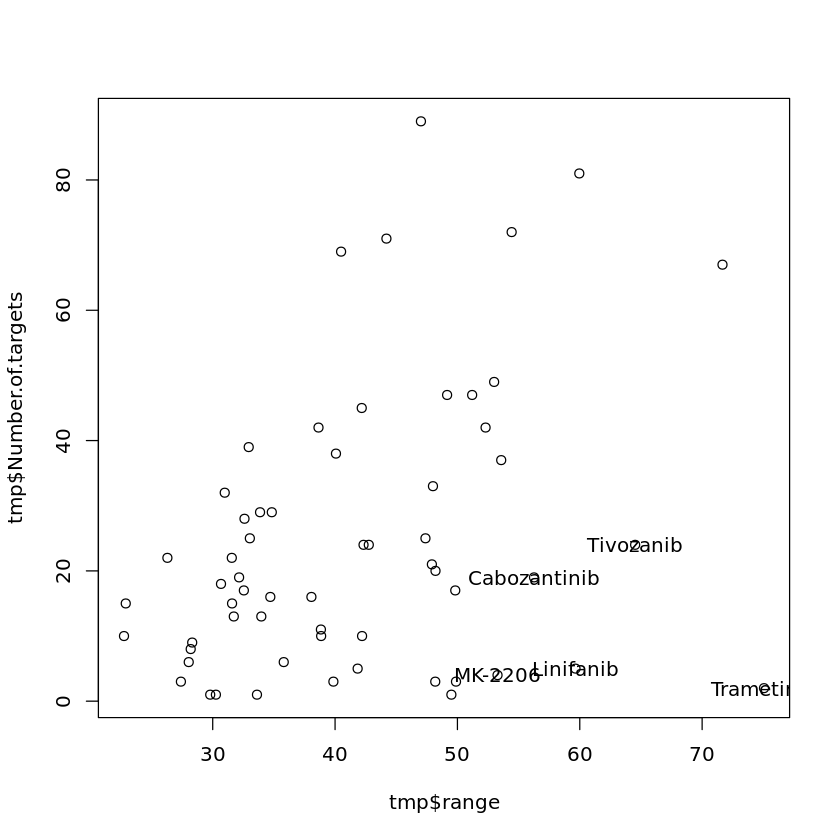

In [130]:
plot(tmp$range, tmp$Number.of.targets)
flag <- tmp$range > 50 & tmp$Number.of.targets < 30
inhibs <- tmp$inhibitor[flag]
# text(tmp$range[flag], tmp$Number.of.targets[flag], labels=tmp$inhibitor[flag])
text(tmp$range[flag], tmp$Number.of.targets[flag], labels=tmp$Drug[flag])
# subset(ohsu.drug.anno, inhibitor %in% inhibs)
# colnames(ohsu.drug.anno)

In [125]:
subset(drug.families, inhibitor %in% inhibs)

,inhibitor,family,value
29,Cabozantinib,RTK_TIE,Yes
30,Cabozantinib,RTK_RET,Yes
31,Cabozantinib,RTK_VEGFRs,Yes
32,Cabozantinib,RTK_ALK_MET,Yes
33,Cabozantinib,RTK_TAM,Yes
34,Cabozantinib,RTK_TYPE_III,Yes
100,Linifanib (ABT-869),RTK_VEGFRs,Yes
101,Linifanib (ABT-869),RTK_TYPE_III,Yes
103,MK-2206,AKT,Yes
104,MK-2206,PI3K_AKT_MTOR,Yes


In [127]:
subset(drug.families, grepl(x=family, "MTOR"))

,inhibitor,family,value
3,A-674563,PI3K_AKT_MTOR,Yes
13,BEZ235,PI3K_MTOR,Yes
14,BEZ235,PI3K_AKT_MTOR,Yes
66,GDC-0941,PI3K_MTOR,Yes
67,GDC-0941,PI3K_AKT_MTOR,Yes
73,GSK690693,PI3K_AKT_MTOR,Yes
78,INK-128,PI3K_MTOR,Yes
79,INK-128,PI3K_AKT_MTOR,Yes
82,Idelalisib,PI3K_MTOR,Yes
83,Idelalisib,PI3K_AKT_MTOR,Yes


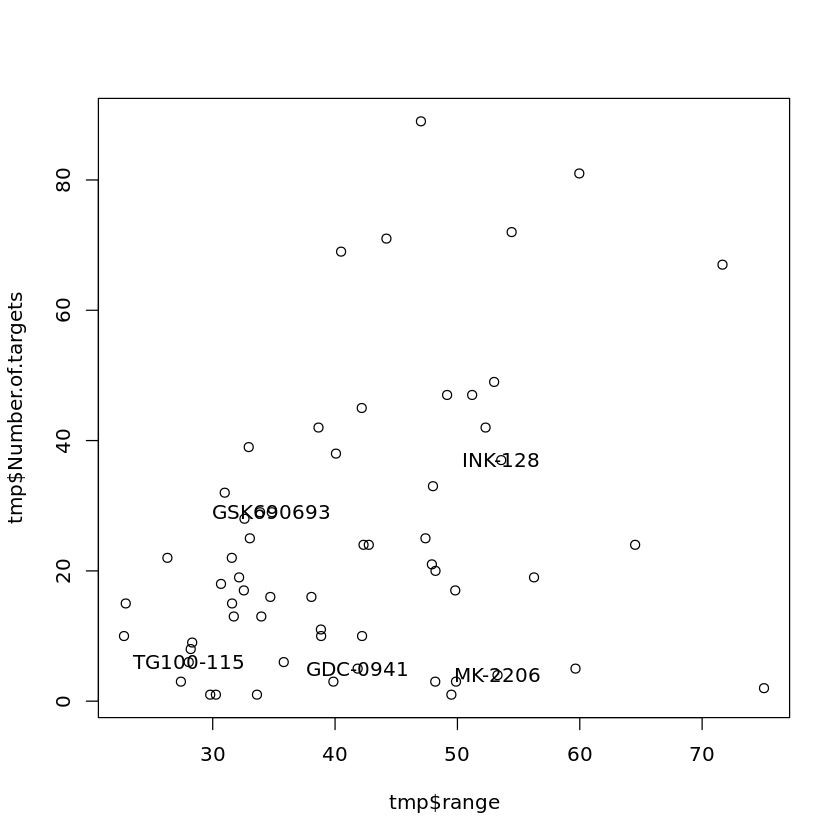

In [131]:
mtor.inhibs <- unique(subset(drug.families, grepl(x=family, "MTOR"))$inhibitor)
plot(tmp$range, tmp$Number.of.targets)
flag <- tmp$inhibitor %in% mtor.inhibs
text(tmp$range[flag], tmp$Number.of.targets[flag], labels=tmp$inhibitor[flag])

In [133]:
head(aucs[["validation"]])

,X17.AAG..Tanespimycin.,A.674563,Afatinib..BIBW.2992.,Alisertib..MLN8237.,AT7519,Axitinib..AG.013736.,AZD1480,Barasertib..AZD1152.HQPA.,Bay.11.7085,BEZ235,...,Vandetanib..ZD6474.,Vargetef,Vatalanib..PTK787.,Vemurafenib..PLX.4032.,Venetoclax,Vismodegib..GDC.0449.,Volasertib..BI.6727.,VX.745,XAV.939,YM.155
17-00066,170.7784,110.53749,156.8137,196.9673,173.2504,190.76394,239.42376,241.22070,274.7972,105.88552,...,221.22761,119.11173,213.4526,230.8921,131.78393,276.7162,163.6628,175.6483,156.64945,286.2640
17-00111,134.4181,100.88218,146.9232,205.9909,NA,51.59203,16.10918,210.63002,284.6460,116.08157,...,182.72315,225.73835,192.8589,NA,NA,238.8292,116.0491,185.4264,143.41445,179.3113
17-00113,206.6379,121.08410,170.6974,222.5485,NA,NA,NA,208.37047,NA,117.22215,...,192.70672,162.68131,242.7435,159.3983,113.27489,286.2740,117.1196,258.5722,140.44643,275.9272
17-00123,153.5129,82.79620,118.0794,181.7065,164.7099,146.18009,170.81947,66.16282,151.1429,74.97307,...,91.49177,45.32122,202.6286,NA,54.28300,286.2740,NA,182.8790,72.65635,286.2640
17-00177,119.2232,69.38349,130.4474,211.2121,132.7936,188.40486,214.93362,124.88523,159.8758,136.39787,...,209.80866,54.75827,226.7306,283.7464,53.91911,250.8332,124.9578,158.6885,215.69023,211.5946
17-00185,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [368]:
grd <- rowMeans(aucs[["validation"]], na.rm=TRUE)
drugs <- colnames(aucs[["validation"]])
names(drugs) <- drugs
grd.cors <- ldply(drugs,
                 .fun = function(drug) data.frame(grd.cor = cor(aucs[["validation"]][,drug], grd, use='pairwise.complete.obs')))
colnames(grd.cors)[1] <- "inhibitor"

In [145]:
tmp$inhibitor.name <- unlist(lapply(tmp$inhibitor, make.names))

In [148]:
tmp <- merge(tmp, grd.cors, by.x = "inhibitor.name", by.y = "inhibitor")


	Pearson's product-moment correlation

data:  tmp$Number.of.targets and tmp$grd.cor
t = 2.7782, df = 58, p-value = 0.007353
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09723893 0.54886414
sample estimates:
      cor 
0.3427019 



	Pearson's product-moment correlation

data:  tmp$Number.of.targets[flag] and tmp$grd.cor[flag]
t = 4.1239, df = 57, p-value = 0.0001224
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2545379 0.6550432
sample estimates:
      cor 
0.4793734 


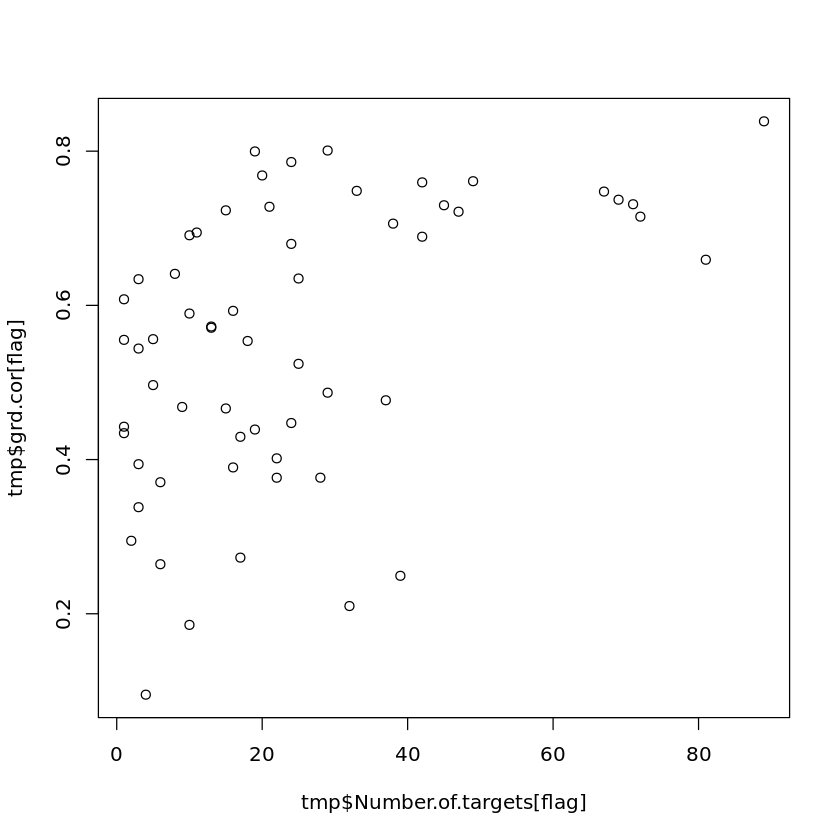

In [154]:
flag <- tmp$grd.cor > 0
plot(tmp$Number.of.targets[flag], tmp$grd.cor[flag])
cor.test(tmp$Number.of.targets, tmp$grd.cor, use='pairwise.complete.obs')
cor.test(tmp$Number.of.targets[flag], tmp$grd.cor[flag], use='pairwise.complete.obs')

In [261]:
klaeger.catds.matrix <- read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=3)
klaeger.catds.matrix <- merge(klaeger.catds.matrix, reconciled[, c("Drug", "inhibitor.name")], by.x="Name", by.y="Drug")
rownames(klaeger.catds.matrix) <- klaeger.catds.matrix$inhibitor.name
klaeger.catds.matrix <- klaeger.catds.matrix[, !(colnames(klaeger.catds.matrix) %in% c("Name", "inhibitor.name"))]
head(klaeger.catds.matrix[,1:5])

,AAK1,ABL1,ABL2,ACAD10,ACAD11
NVP.ADW742,NA,NA,NA,NA,NA
Afatinib..BIBW.2992.,NA,NA,NA,NA,NA
Alisertib..MLN8237.,NA,NA,0.06126227,0.2028248,NA
Flavopiridol,NA,NA,NA,NA,NA
AT7519,NA,NA,NA,NA,NA
Axitinib..AG.013736.,0.04017746,0.05488333,0.05228582,NA,NA


In [338]:
symbols.to.ensg.mapping <- function(symbols) {
  suppressPackageStartupMessages(p_load(mygene))
  dummy <- data.frame(query = symbols, ensembl = NA)
  bm <- tryCatch({queryMany(symbols, scopes="symbol", fields=c("ensembl.gene"), species="human")}, error = function(e) { return(dummy) })
  flag <- grepl(pattern="ensembl", colnames(bm))
  if(length(which(flag)) != 1) {
    stop(paste0("Could not find ensembl col in: ", paste(colnames(bm), collapse=" "), "\n"))
  }
  ensg.col <- colnames(bm)[flag]
  bm <- bm[, c("query", ensg.col)]
  lst <- bm[,ensg.col]
  names(lst) <- bm$query
  bm <- ldply(lst, .fun = function(comp) data.frame(unlist(comp)))
  colnames(bm) <- c("symbol", "ensg")
  bm <- bm[!(bm$ensg %in% c("")),,drop=F]
  bm <- bm[!is.na(bm$ensg) & !is.na(bm$symbol),,drop=F]
  bm
}

symbol.ensg.map <- symbols.to.ensg.mapping(colnames(klaeger.catds.matrix))
symbol.ensg.map$symbol <- as.character(symbol.ensg.map$symbol)
symbol.ensg.map$ensg <- as.character(symbol.ensg.map$ensg)

klaeger.catds.targets <- read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=2)
klaeger.catds.targets <- merge(klaeger.catds.targets, reconciled.tbls[["most.global"]][, c("Drug", "inhibitor.name")], by.x="Drug", by.y="Drug")



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [262]:
symbols.to.ensg.mapping <- function(symbols) {
  suppressPackageStartupMessages(p_load(mygene))
  dummy <- data.frame(query = symbols, ensembl = NA)
  bm <- tryCatch({queryMany(symbols, scopes="symbol", fields=c("ensembl.gene"), species="human")}, error = function(e) { return(dummy) })
  flag <- grepl(pattern="ensembl", colnames(bm))
  if(length(which(flag)) != 1) {
    stop(paste0("Could not find ensembl col in: ", paste(colnames(bm), collapse=" "), "\n"))
  }
  ensg.col <- colnames(bm)[flag]
  bm <- bm[, c("query", ensg.col)]
  lst <- bm[,ensg.col]
  names(lst) <- bm$query
  bm <- ldply(lst, .fun = function(comp) data.frame(unlist(comp)))
  colnames(bm) <- c("symbol", "ensg")
  bm <- bm[!(bm$ensg %in% c("")),,drop=F]
  bm <- bm[!is.na(bm$ensg) & !is.na(bm$symbol),,drop=F]
  bm
}

symbol.ensg.map <- symbols.to.ensg.mapping(colnames(klaeger.catds.matrix))
symbol.ensg.map$symbol <- as.character(symbol.ensg.map$symbol)
symbol.ensg.map$ensg <- as.character(symbol.ensg.map$ensg)

Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [263]:
drugs <- rownames(klaeger.catds.matrix)
names(drugs) <- drugs
ensg.drug.targets <- llply(drugs,
                          .fun = function(drug) {
                              targets <- colnames(klaeger.catds.matrix)
                              targets <- targets[!is.na(klaeger.catds.matrix[drug,targets])]
                              return(targets)
                              targets <- targets[targets %in% symbol.ensg.map$symbol]
                              subset(symbol.ensg.map, symbol %in% targets[!is.na(klaeger.catds.matrix[drug,targets])])$ensg
                          })

In [264]:
foo <- ldply(ensg.drug.targets, .fun = function(lst) data.frame(n=length(lst)))
colnames(foo)[1] <- "Drug"

In [265]:
foo

Drug,n
NVP.ADW742,23
Afatinib..BIBW.2992.,8
Alisertib..MLN8237.,15
Flavopiridol,27
AT7519,19
Axitinib..AG.013736.,21
AZD1480,18
SNS.032..BMS.387032.,20
Bosutinib..SKI.606.,41
Cabozantinib,19


In [270]:
klaeger.catds.targets <- read.xlsx("EMS82808-supplement-Table_S6.xlsx", sheet=2)
klaeger.catds.targets <- merge(klaeger.catds.targets, reconciled[, c("Drug", "inhibitor.name")], by.x="Drug", by.y="Drug")

In [271]:
symbol.drug.targets <- dlply(klaeger.catds.targets, .variables = c("inhibitor.name"), .fun = function(df) return(df$Target))
ensg.drug.targets <- llply(symbol.drug.targets, .fun = function(targets) {
    subset(symbol.ensg.map, symbol %in% targets)$ensg
})

In [272]:
foo <- ldply(ensg.drug.targets, .fun = function(lst) data.frame(n=length(lst)))
colnames(foo)[1] <- "Drug"
foo

Drug,n
Afatinib..BIBW.2992.,8
Alisertib..MLN8237.,14
AT7519,20
Axitinib..AG.013736.,19
AZD1480,18
Bosutinib..SKI.606.,40
Cabozantinib,26
Cabozantinib..XL.184.,26
Canertinib..CI.1033.,13
Cediranib..AZD2171.,21


In [313]:
train.models.using.targets <- function(auc.matrix, expr.matrix, drug.targets) {
    colnames(auc.matrix) <- make.names(colnames(auc.matrix))
    auc.matrix <- t(auc.matrix)
    expr.matrix <- t(expr.matrix)
    common.samples <- intersect(rownames(expr.matrix), rownames(auc.matrix))
    expr.matrix <- expr.matrix[common.samples,]
    auc.matrix <- auc.matrix[common.samples,]
    drugs <- names(drug.targets)
    drugs <- drugs[drugs %in% colnames(auc.matrix)]
    names(drugs) <- drugs
    fits <- llply(drugs, .parallel = FALSE,
                 .fun = function(drug) {
                     y.var <- drug
                     xs <- drug.targets[[drug]]
                     xs <- xs[xs %in% colnames(expr.matrix)]
                     data.mat <- cbind(auc.matrix[,drug,drop=F], expr.matrix[,xs,drop=FALSE])
                     fit <- lm(formula(paste0(y.var, ' ~ 0 + ', paste0(xs, collapse=" + "))), data=as.data.frame(data.mat))
                     fit
                 })
    fits
}

test.models <- function(fits, auc.matrix, expr.matrix) {
    colnames(auc.matrix) <- make.names(colnames(auc.matrix))
    auc.matrix <- t(auc.matrix)
    expr.matrix <- t(expr.matrix)
    common.samples <- intersect(rownames(expr.matrix), rownames(auc.matrix))
    expr.matrix <- expr.matrix[common.samples,]
    auc.matrix <- auc.matrix[common.samples,]
    drugs <- names(fits)
    drugs <- drugs[drugs %in% colnames(auc.matrix)]
    names(drugs) <- drugs
    res <- llply(drugs, .parallel = TRUE,
                 .fun = function(drug) {
                     y.var <- drug
                     #xs <- symbol.drug.targets[[drug]]
                     #xs <- xs[xs %in% colnames(expr.matrix)]
                     pred <- predict(fits[[drug]], newdata = as.data.frame(expr.matrix))
                     data.frame(pred = pred, obs = as.numeric(auc.matrix[,drug,drop=T]), sample = rownames(auc.matrix))
                })
    res
}


In [305]:
fits <- train.models.using.targets(t(aucs[['training']]), symbol.exprs[['training']], symbol.drug.targets)

In [314]:
res <- test.models(fits, t(aucs[['validation']]), symbol.exprs[['validation']])
cors <- ldply(res, .fun = function(df) {
    data.frame(cor.p = cor(df$pred, df$obs, use='pairwise.complete.obs'),
               cor.s = cor(df$pred, df$obs, use='pairwise.complete.obs', method='spearman'))
    })
colnames(cors)[1] <- "inhibitor"

In [321]:
cors <- ldply(res, .fun = function(df) {
    data.frame(cor.p = cor(df$pred, df$obs, use='pairwise.complete.obs'),
               cor.s = cor(df$pred, df$obs, use='pairwise.complete.obs', method='spearman'))
    })
colnames(cors)[1] <- "inhibitor"

In [407]:
all.tbl$inhibitor.name <- make.names(all.tbl$inhibitor)
tk.tbl <- merge(all.tbl, cors, by.x = "inhibitor.name", by.y = "inhibitor")

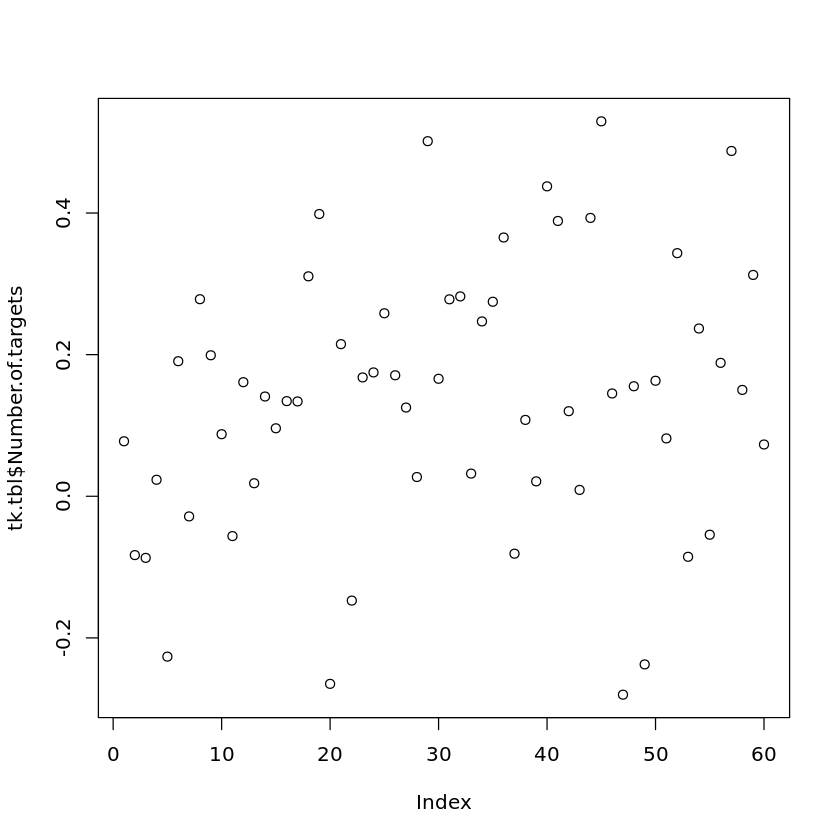

In [332]:
plot(tk.tbl$mean.correlation - tk.tbl$cor.s, tk.tbl$Number.of.targets)

In [355]:
klaeger.reconciled.synId <- "syn26320868"
klaeger.targets.synId <- "syn26320930"

klaeger.reconciled <- read.csv.from.synapse(klaeger.reconciled.synId, sep="\t", comment.char="", header=TRUE)
klaeger.targets <- read.csv.from.synapse(klaeger.targets.synId, sep="\t", header=TRUE)


In [356]:
head(klaeger.targets)

Drug,Target,At,CATDS,inhibitor.name,inhibitor
AEW-541,HCK,622.7898,0.07185662,NVP.ADW742,NVP-ADW742
AEW-541,BMPR1B,1442.2571,0.05453567,NVP.ADW742,NVP-ADW742
AEW-541,ROCK2,18264.8265,0.02902704,NVP.ADW742,NVP-ADW742
AEW-541,ADCK3,835.3055,0.06500675,NVP.ADW742,NVP-ADW742
AEW-541,CSNK1E,60522.8524,0.02590251,NVP.ADW742,NVP-ADW742
AEW-541,PTK6,1939.2480,0.04969758,NVP.ADW742,NVP-ADW742


In [416]:
all.tbl <- merge(drug.clusters, drug.range.tbl, all.x = TRUE)
all.tbl <- merge(all.tbl, mean.perf.tbl, all.x = TRUE)
all.tbl <- all.tbl[!(all.tbl$inhibitor == "GRD"),]
ohsu.drug.targets <- read.table("ohsu-drug-targets.tsv", sep="\t", header=TRUE)
# Ensure a minimum drug binding
cutoff <- -log10(100*10^-9)
ohsu.drug.targets$log.num.targets <- log10(ohsu.drug.targets$num.targets)
ohsu.drug.targets[ohsu.drug.targets$max.mean.pchembl < cutoff, "num.targets"] <- NA
ohsu.drug.targets[ohsu.drug.targets$max.mean.pchembl < cutoff, "log.num.targets"] <- NA
all.tbl <- merge(all.tbl, ohsu.drug.targets[, c("inhibitor", "num.targets", "log.num.targets", "max.mean.pchembl")], all.x=TRUE)
all.tbl <- merge(all.tbl, multi.vs.uni.df, all.x=TRUE)
all.tbl$inhibitor.name <- make.names(all.tbl$inhibitor)
ki.tbl <- merge(all.tbl, klaeger.reconciled, by.x = c("inhibitor", "inhibitor.name"), by.y = c("inhibitor", "inhibitor.name"))
print(dim(ki.tbl))

[1] 60 19


In [417]:
grd <- rowMeans(aucs[["validation"]], na.rm=TRUE)
drugs <- colnames(aucs[["validation"]])
names(drugs) <- drugs
grd.cors <- ldply(drugs,
                 .fun = function(drug) data.frame(grd.cor = cor(aucs[["validation"]][,drug], grd, use='pairwise.complete.obs', method="spearman")))
colnames(grd.cors)[1] <- "inhibitor"

In [418]:
ki.tbl <- merge(ki.tbl, grd.cors, by.x = "inhibitor.name", by.y = "inhibitor")
print(dim(ki.tbl))

[1] 60 20


In [438]:
colnames(ki.tbl)

[1] "inhibitor.name"         "inhibitor"              "cluster"               
 [4] "range"                  "mean.correlation"       "num.targets"           
 [7] "log.num.targets"        "max.mean.pchembl"       "multi.vs.uni"          
[10] "Drug"                   "klaeger.smiles"         "smiles"                
[13] "CATDS"                  "Number.of.targets"      "Gini"                  
[16] "Selectivity"            "Partition.index.single" "CATDS.single"          
[19] "Entropy"                "grd.cor"

In [419]:
suppressPackageStartupMessages(p_load(GGally))


In [420]:
cols <- c("mean.correlation", "Number.of.targets", "range", "grd.cor")
labels <- c("Performance", "Num Targets", "Dynamic Range", "GRD")
g <- ggpairs(ki.tbl[,cols], columnLabels = labels, lower = list(continuous = "smooth"))
png("perf-targets-range-grd.png")
print(g)
d <- dev.off()

pdf("perf-targets-range-grd.pdf")
print(g)
d <- dev.off()


In [441]:
cols <- c("mean.correlation", "Number.of.targets", "range", "Gini", "Selectivity", "Partition.index.single", "Entropy", "CATDS.single")
labels <- c("Performance", "Num Targets", "Dynamic Range", "Gini", "Selectivity", "Partition Index", "Entropy", "CATDS")
g <- ggpairs(ki.tbl[,cols], columnLabels = labels, lower = list(continuous = "smooth"))
png("perf-vs-all-specificity-stats.png")
print(g)
d <- dev.off()

pdf("perf-vs-all-specificity-stats.pdf")
print(g)
d <- dev.off()


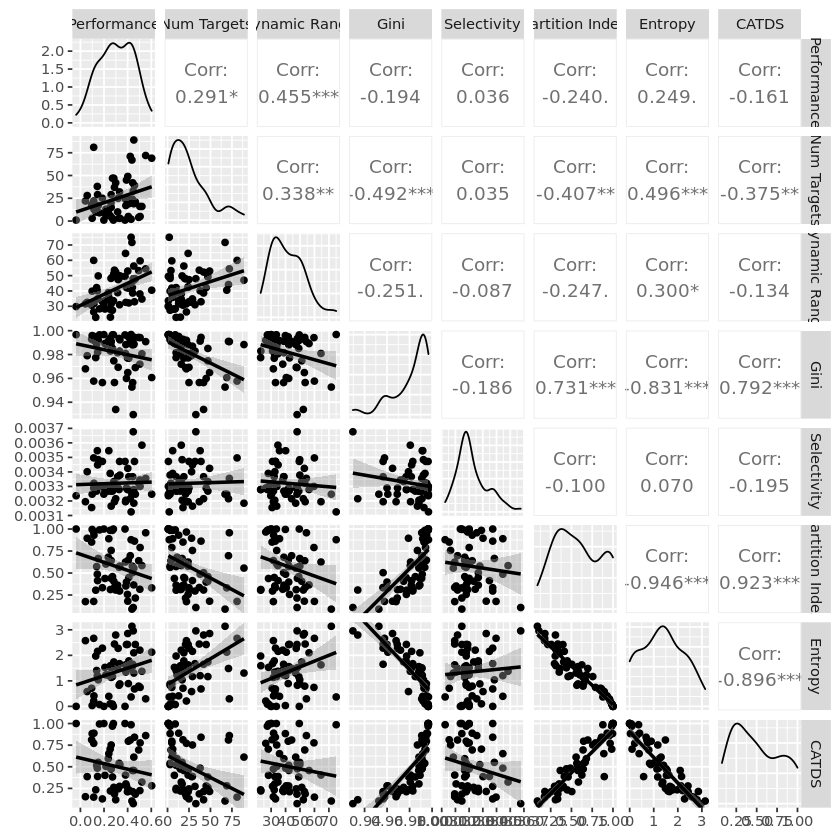

In [442]:
print(g)

In [421]:
library(dplyr)
all.tbl <- merge(all.tbl, grd.cors, by.x = "inhibitor.name", by.y = "inhibitor")
all.cluster.tbl <- all.tbl %>%
  group_by(cluster) %>%
  summarise_at(c("mean.correlation", "range", "grd.cor"), mean, na.rm= TRUE)


In [423]:
colnames(all.cluster.tbl)

[1] "cluster"          "mean.correlation" "range"            "grd.cor"

In [426]:
cols <- c("mean.correlation", "range", "grd.cor")
g <- ggpairs(all.cluster.tbl[,cols], columnLabels = c("Performance", "Dynamic Range", "GRD"), lower = list(continuous = "smooth"))
png("perf-targets-range-grd-cluster.png")
print(g)
d <- dev.off()

pdf("perf-targets-range-grd-cluster.pdf")
print(g)
d <- dev.off()

In [434]:
lm_corr_eqn <- function(df, method = "pearson", display.r2 = FALSE, display.pval = FALSE){
    m <- lm(y ~ x, df);
    ct <- cor.test(df$x, df$y, method = method)
    estimate <- as.numeric(ct$estimate)
    if(display.r2 == TRUE) { estimate <- estimate*estimate }
    pval <- ct$p.value
    cat(paste0("method = ", method, " estimate = ", estimate, " pval = ", pval, "\n"))
    eq <- NULL
    digits <- 2
    if((method == "pearson") && (display.r2 == TRUE)) { 
      if(display.pval) { 
        eq <- substitute(italic(r)^2~"="~est*","~~italic(p)~"="~pval, 
                         list(est = format(estimate, digits=digits, scientific=0),
                              pval = format(pval, digits=digits, scientific=0)))
      } else {
        eq <- substitute(italic(r)^2~"="~est, 
                         list(est = format(estimate, digits=digits, scientific=0)))

      }
    } else if((method == "pearson") && (display.r2 == FALSE)) {
      if(display.pval) {
        eq <- substitute(italic(r)~"="~est*","~~italic(p)~"="~pval, 
                         list(est = format(estimate, digits=digits, scientific=0),
                              pval = my_format(pval)))
                              # pval = format(pval, digits=digits, scientific=0)))
      } else {
        eq <- substitute(italic(r)~"="~est, 
                         list(est = format(estimate, digits=digits, scientific=0)))

      }
    } else if((method == "spearman") && (display.r2 == FALSE)) {
      if(display.pval) { 
        eq <- substitute(rho~"="~est*","~~italic(p)~"="~pval, 
                         list(est = format(estimate, digits=digits, scientific=0),
                              pval = format(pval, digits=digits, scientific=0)))
      } else {
        eq <- substitute(rho~"="~est, 
                         list(est = format(estimate, digits=digits, scientific=0)))

      }
    } else {
      stop(paste("lm_corr_eqn does not know how to handle method = ", method,  " display.r2 = ", display.r2, "\n"))
    }
    as.character(as.expression(eq));                 
}

plot.correlation <- function(x, y, labels = NULL, colors = NULL, display.r2 = FALSE, method = "pearson", display.pval = FALSE, xoffset = 0.5, yoffset = 0.8,
                             sz = 25, geom.text.size = 5, ...) {
  df <- data.frame(x = x, y = y)
  if(!is.null(labels)) {
    df$labels <- labels
  }
  g <- NULL
  if(is.null(labels)) {
    g <- ggplot(df, aes(x = x, y = y))
  } else {
    g <- ggplot(df, aes(x = x, y = y, label = labels))
  }
  if(!is.null(colors)) {
    g <- g + geom_point(aes(colour = colors))
  } else {
    g <- g + geom_point()
  }
  if(!is.null(labels)) {
    g <- g + geom_text(vjust = "inward", hjust = "inward")
  }
  g <- g + geom_smooth(data = df, aes(x = x, y = y), method='lm')
  x.min <- min(df$x, na.rm=TRUE)
  x.max <- max(df$x, na.rm=TRUE)
  y.min <- min(df$y, na.rm=TRUE)
  y.max <- max(df$y, na.rm=TRUE)

  ylimits <- NULL

  xlimits <- ggplot_build(g)$layout$panel_params[[1]]$x.range
  ylimits <- ggplot_build(g)$layout$panel_params[[1]]$y.range

  g <- g + geom_text(size = geom.text.size, x = xlimits[1] + xoffset * (xlimits[2] - xlimits[1]), y = ylimits[1] + yoffset * (ylimits[2] - ylimits[1]),
                     label = lm_corr_eqn(df, method = method, display.r2 = display.r2, display.pval = display.pval), parse=TRUE, ...)
  g <- g +theme(text = element_text(size = sz),
             axis.text.x = element_text(size=sz),
             axis.text.y = element_text(size=sz),
             axis.title.x = element_text(size=sz),
             axis.title.y = element_text(size=sz),
             title = element_text(size=sz),
             plot.title = element_text(hjust = 0.5, size=sz))
  g
}



`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


method = pearson estimate = 0.819386585340337 pval = 0.0240968267333356


`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


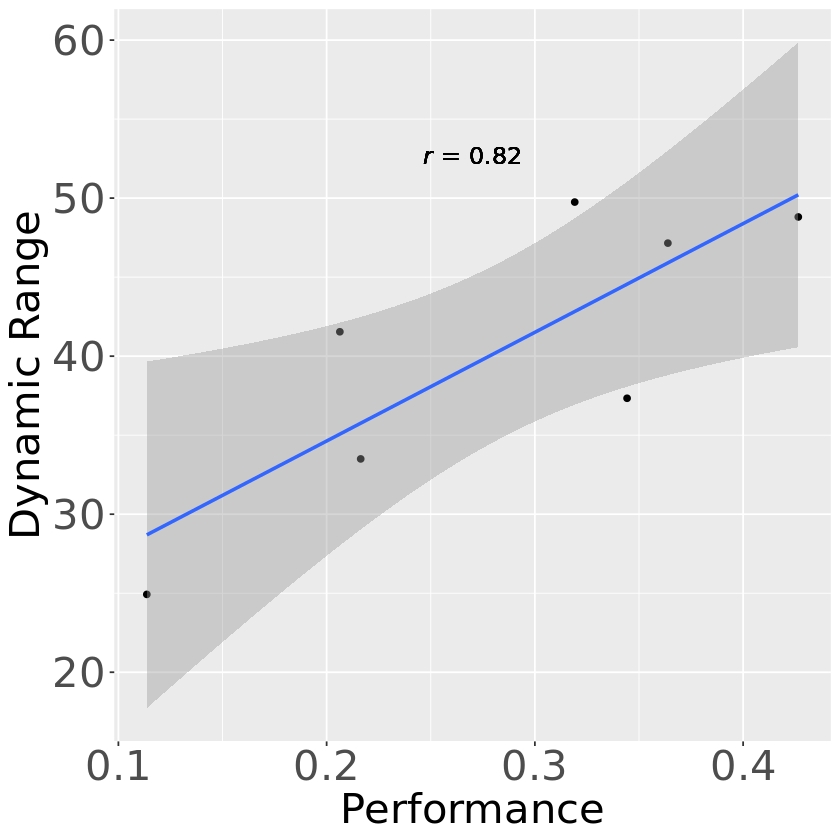

In [437]:
g <- plot.correlation(all.cluster.tbl$mean.correlation, all.cluster.tbl$range)
g <- g + xlab("Performance") + ylab("Dynamic Range")
g

png("perf-vs-range-cluster.png")
print(g)
d <- dev.off()

pdf("perf-vs-range-cluster.pdf")
print(g)
d <- dev.off()

Warning message in `[<-.factor`(`*tmp*`, !flag, value = ""):
"invalid factor level, NA generated"`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


method = pearson estimate = 0.337933184251575 pval = 0.00827262025494789


`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 55 rows containing missing values (geom_text)."`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 55 rows containing missing values (geom_text)."`geom_smooth()` using formula 'y ~ x'
Warning message:
"Removed 55 rows containing missing values (geom_text)."

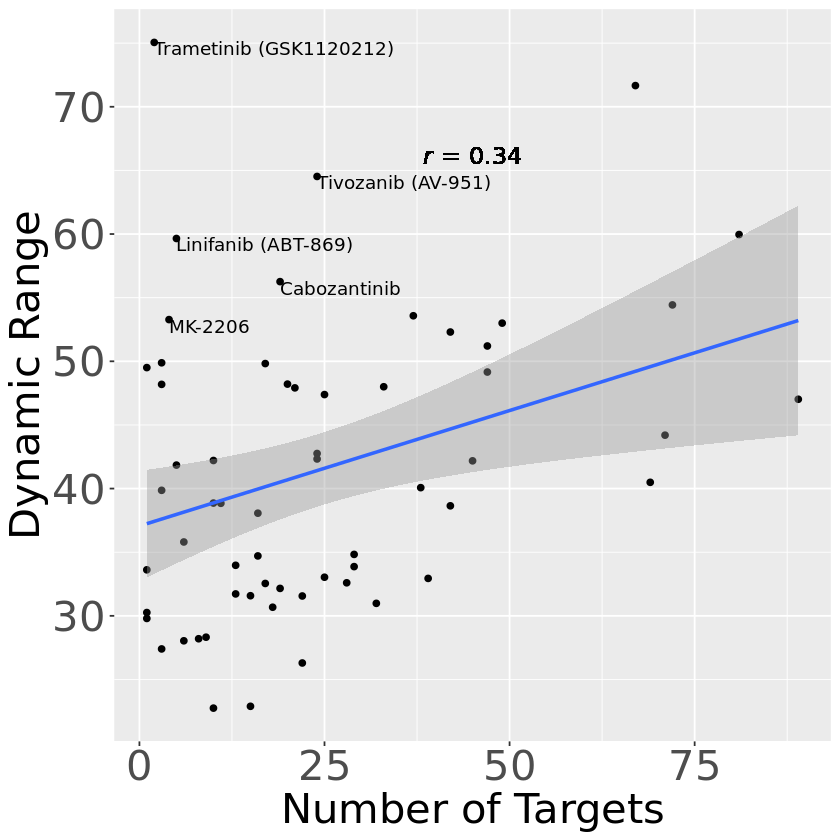

In [457]:
labels <- ki.tbl$inhibitor
flag <- ki.tbl$Number.of.targets < 25 & ki.tbl$range > 50
labels[!flag] <- "" 

g <- plot.correlation(ki.tbl$Number.of.targets, ki.tbl$range, labels=labels)
g <- g + xlab("Number of Targets") + ylab("Dynamic Range")
g

png("num-targets-vs-range.png")
print(g)
d <- dev.off()

pdf("num-targets-vs-range.pdf")
print(g)
d <- dev.off()



In [456]:
png("num-targets-vs-range-outliers.png")
grid.table(subset(drug.families, inhibitor %in% ki.tbl$inhibitor[flag])[, c("inhibitor", "family")], rows = NULL)
d <- dev.off()

In [463]:
lmf <- lm(formula("mean.correlation ~ 0 + range + Number.of.targets"), data = ki.tbl)
summary(lmf)


Call:
lm(formula = formula("mean.correlation ~ 0 + range + Number.of.targets"), 
    data = ki.tbl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36334 -0.08991  0.00628  0.09402  0.27666 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
range             0.0065597  0.0006282  10.441 6.11e-15 ***
Number.of.targets 0.0010187  0.0008306   1.226    0.225    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1298 on 58 degrees of freedom
Multiple R-squared:  0.8546,	Adjusted R-squared:  0.8496 
F-statistic: 170.5 on 2 and 58 DF,  p-value: < 2.2e-16
